# Modelo Neuro-Fuzzy Híbrido (FIS Sugeno con Consecuentes Aprendidos)

**Objetivo:**
El objetivo de este notebook es implementar un sistema híbrido que combine lógica difusa (para las premisas de las reglas) y aprendizaje automático (para los consecuentes de las reglas) para aproximar una función no lineal unidimensional. Este enfoque es una simplificación conceptual de ANFIS, donde las funciones de pertenencia de las premisas son fijas, pero los parámetros de los consecuentes de las reglas de tipo Sugeno se aprenden de los datos. Se utilizarán `scikit-fuzzy` y `scikit-learn`.

## 1. Carga de Librerías y Configuración Inicial

**Propósito de esta sección:**
Importar todas las bibliotecas necesarias y configurar el entorno para el análisis.

**Bibliotecas Clave:**
* **`numpy`**: Para operaciones numéricas y generación de datos.
* **`matplotlib.pyplot`**: Para la creación de gráficos.
* **`skfuzzy`**: Para definir funciones de pertenencia y operaciones difusas.
* **`sklearn.model_selection`**: Para dividir datos en conjuntos de entrenamiento y prueba.
* **`sklearn.linear_model`**: Para `LinearRegression` (para aprender los consecuentes).
* **`sklearn.metrics`**: Para métricas de evaluación como Error Cuadrático Medio (MSE).

In [9]:
# Comandos mágicos de IPython (opcional en scripts)
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# Importación de bibliotecas
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz # Para funciones de pertenencia
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Configuración de estilo y visualización
plt.rcParams['figure.figsize'] = [12, 7]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10
sns_style_set = False
try:
    import seaborn as sns
    sns.set(style="whitegrid")
    sns_style_set = True
except ImportError:
    print("Seaborn no está instalado, se usarán los estilos por defecto de Matplotlib.")

## 2. Funciones Personalizadas

### Descripción de la Función: `generar_datos_sinteticos_1d`
(Misma función que antes)

In [11]:
def generar_datos_sinteticos_1d(n_puntos=100, rango_x=(-7, 7), ruido_std=0.08):
    print(f"Generando {n_puntos} puntos de datos sintéticos 1D...")
    x_original = np.linspace(rango_x[0], rango_x[1], n_puntos)
    y_verdaderos = np.sin(x_original) * np.exp(-(x_original / 4)**2)
    ruido = np.random.normal(0, ruido_std, size=n_puntos)
    y_observados = y_verdaderos + ruido
    X = x_original.reshape(-1, 1) # Asegurar que X sea (n_puntos, 1)
    
    plt.figure(figsize=(10,6))
    plt.scatter(X.flatten(), y_observados, label='Datos Observados (con ruido)', color='blue', s=20, alpha=0.7)
    plt.plot(X.flatten(), y_verdaderos, label='Función Verdadera (sin ruido)', color='red', linestyle='--')
    plt.xlabel('Característica X')
    plt.ylabel('Objetivo y')
    plt.title('Datos Sintéticos Generados para Regresión 1D')
    plt.legend()
    plt.show()
    return X, y_observados

### Descripción de la Función: `definir_funciones_pertenencia_fijas`

**Objetivo Principal:**
Definir un conjunto de funciones de pertenencia (MFs) fijas para una variable de entrada.

**Características:**
* **Entrada:**
    * `universo_x` (np.ndarray): Rango de valores sobre el cual definir las MFs.
    * `num_mfs` (int): Número de MFs a crear.
    * `mf_type` (str): Tipo de MF de `skfuzzy` (ej: 'gaussmf', 'trimf', 'gbellmf').
* **Procesamiento:**
    * Determina los centros y parámetros de las MFs para cubrir el universo.
* **Valor de Retorno:**
    * `mf_params_list` (list): Lista de parámetros para cada MF.
    * `mf_objects` (list): Lista de objetos/arrays MF evaluados sobre el universo (opcional, para visualización).

In [12]:
def definir_funciones_pertenencia_fijas(universo_entrada_np, num_mfs=5, mf_type='gaussmf'):
    """
    Define un conjunto de funciones de pertenencia fijas sobre un universo dado.
    Retorna una lista de tuplas (parámetros_mf, tipo_mf) y opcionalmente los MFs evaluados.
    """
    print(f"Definiendo {num_mfs} MFs fijas de tipo '{mf_type}'...")
    
    mfs_definitions = [] # Almacenará tuplas (tipo, params_dict)
    
    min_val = np.min(universo_entrada_np)
    max_val = np.max(universo_entrada_np)
    
    # Crear un universo denso para evaluar las MFs para visualización
    x_grafico = np.linspace(min_val, max_val, 300)
    mfs_evaluadas_grafico = []

    if num_mfs > 0:
        centers = np.linspace(min_val, max_val, num_mfs)
        if num_mfs > 1:
            width_param = (max_val - min_val) / (num_mfs - 1) # Distancia entre centros como sigma/width
        else: # Un solo MF
            width_param = (max_val - min_val) if (max_val - min_val) > 0 else 1.0 # Ancho que cubra el rango

        if width_param == 0: width_param = 0.1 # Evitar sigma/width cero

        for i in range(num_mfs):
            center = centers[i]
            if mf_type == 'gaussmf':
                # skfuzzy.gaussmf(x, mean, sigma)
                sigma = width_param / 2.0 # Ajustar sigma
                mfs_definitions.append({'type': 'gaussmf', 'params': {'mean': center, 'sigma': sigma}})
                mfs_evaluadas_grafico.append(fuzz.gaussmf(x_grafico, center, sigma))
            elif mf_type == 'trimf':
                # skfuzzy.trimf(x, abc) donde abc son los puntos del triángulo
                # Crear triángulos que se solapen un poco
                punto_a = center - width_param
                punto_b = center
                punto_c = center + width_param
                # Asegurar que los puntos estén dentro del rango del universo o cerca
                punto_a = max(min_val - 0.1*(max_val-min_val), punto_a) # Permitir un poco fuera para el primer MF
                punto_c = min(max_val + 0.1*(max_val-min_val), punto_c) # Permitir un poco fuera para el último MF

                mfs_definitions.append({'type': 'trimf', 'params': {'abc': [punto_a, punto_b, punto_c]}})
                mfs_evaluadas_grafico.append(fuzz.trimf(x_grafico, [punto_a, punto_b, punto_c]))
            elif mf_type == 'gbellmf':
                # skfuzzy.gbellmf(x, a, b, c) a: ancho, b: pendiente, c: centro
                # a (width), b (slope), c (center)
                a_gbell = width_param / 2.0
                b_gbell = 2.0 # Pendiente típica
                mfs_definitions.append({'type': 'gbellmf', 'params': {'a': a_gbell, 'b': b_gbell, 'c': center}})
                mfs_evaluadas_grafico.append(fuzz.gbellmf(x_grafico, a_gbell, b_gbell, center))
            else:
                raise ValueError(f"Tipo de MF '{mf_type}' no soportado en esta función.")
    
    # Visualizar las MFs definidas
    plt.figure(figsize=(10,5))
    for i, y_mf in enumerate(mfs_evaluadas_grafico):
        plt.plot(x_grafico, y_mf, label=f'MF {i+1}')
    plt.title(f'Funciones de Pertenencia Fijas ({num_mfs} de tipo "{mf_type}")')
    plt.xlabel('Universo de Entrada X')
    plt.ylabel('Grado de Pertenencia')
    plt.legend()
    plt.grid(True)
    plt.show()
            
    return mfs_definitions

### Descripción de la Función: `calcular_grados_activacion`

**Objetivo Principal:**
Calcular los grados de activación (fuerza de disparo) de cada regla para cada punto de dato.
En este caso 1D, cada MF de entrada define una regla, por lo que es el grado de pertenencia a esa MF.

**Características:**
* **Entrada:**
    * `X_input` (np.ndarray): Datos de entrada (N_samples x 1 feature).
    * `mfs_definitions` (list): Lista de definiciones de MFs (diccionarios con 'type' y 'params').
* **Procesamiento:**
    * Para cada punto de dato y cada MF, calcula el grado de pertenencia.
* **Valor de Retorno:**
    * `activations` (np.ndarray): Matriz (N_samples x Num_MFs) con los grados de activación.

In [13]:
def calcular_grados_activacion(X_input_np, mfs_definitions):
    """
    Calcula los grados de activación de las reglas (grados de pertenencia a las MFs de entrada).
    X_input_np debe ser un array de (N_samples, 1) para este caso 1D.
    """
    n_samples = X_input_np.shape[0]
    num_mfs = len(mfs_definitions)
    activations = np.zeros((n_samples, num_mfs))
    
    x_values = X_input_np.flatten() # Trabajar con un array 1D de x

    for i in range(n_samples):
        for j in range(num_mfs):
            mf_def = mfs_definitions[j]
            mf_type = mf_def['type']
            params = mf_def['params']
            
            if mf_type == 'gaussmf':
                activations[i, j] = fuzz.gaussmf(x_values[i], **params)
            elif mf_type == 'trimf':
                activations[i, j] = fuzz.trimf(x_values[i], **params['abc'])
            elif mf_type == 'gbellmf':
                activations[i, j] = fuzz.gbellmf(x_values[i], **params)
    
    # Normalizar las activaciones (opcional, pero común en FIS Sugeno para la salida ponderada)
    # sum_activations = np.sum(activations, axis=1, keepdims=True)
    # # Evitar división por cero si todas las activaciones son cero para una muestra
    # sum_activations[sum_activations == 0] = 1e-9 # Un valor pequeño para evitar NaN/inf
    # normalized_activations = activations / sum_activations
    # return normalized_activations
    return activations # Devolver sin normalizar, la normalización se hará al calcular la salida final

### Descripción de la Función: `aprender_consecuentes_sugeno`

**Objetivo Principal:**
Aprender los parámetros de los consecuentes de las reglas Sugeno de primer orden (`y_i = a_i * x + b_i`) usando regresión lineal.

**Características:**
* **Entrada:**
    * `X_train_np` (np.ndarray): Datos de entrada de entrenamiento (N x 1).
    * `y_train_np` (np.ndarray): Datos de salida de entrenamiento (N,).
    * `rule_activations_train` (np.ndarray): Grados de activación de las reglas para los datos de entrenamiento (N x Num_MFs).
* **Procesamiento:**
    * Construye la matriz de regresión para el sistema de ecuaciones lineales.
    * Resuelve para los coeficientes `a_i` y `b_i` de cada regla.
* **Valor de Retorno:**
    * `consequent_params` (np.ndarray): Matriz (Num_MFs x 2) con los coeficientes `[a_i, b_i]` para cada regla.

In [14]:
def aprender_consecuentes_sugeno(X_train_np, y_train_np, rule_activations_train):
    """
    Aprende los parámetros (a_i, b_i) para los consecuentes de reglas Sugeno de primer orden:
    y_i = a_i * x + b_i
    """
    print("Aprendiendo parámetros de los consecuentes de las reglas Sugeno...")
    n_samples = X_train_np.shape[0]
    num_rules = rule_activations_train.shape[1] # Número de MFs = Número de reglas

    # La salida del FIS Sugeno es: Y = sum(w_i * y_i) / sum(w_i)
    # donde y_i = a_i * x + b_i.
    # Entonces: Y * sum(w_i) = sum(w_i * (a_i * x + b_i))
    # Y * sum(w_i) = sum(w_i * a_i * x + w_i * b_i)
    # Esto es un problema de mínimos cuadrados.
    # Queremos encontrar los parámetros [a1, b1, a2, b2, ..., aM, bM] (M = num_rules)
    
    # Construir la matriz de diseño A_reg: (n_samples, num_rules * 2)
    # Cada par de columnas será w_i*x y w_i
    A_reg = np.zeros((n_samples, num_rules * 2))
    
    x_flat_train = X_train_np.flatten()

    for i in range(num_rules):
        w_i = rule_activations_train[:, i]
        A_reg[:, 2*i]     = w_i * x_flat_train # Coeficiente para a_i
        A_reg[:, 2*i + 1] = w_i                # Coeficiente para b_i
        
    # El vector objetivo b_reg es y_train (las salidas reales)
    # (No es y_train * sum(w_i) si formulamos la regresión para predecir Y_total directamente
    # desde una combinación lineal de w_i*x_i y w_i, donde los pesos de la regresión son los a_i, b_i.
    # La normalización por sum(w_i) se hace en la predicción.)
    # Sin embargo, el método estándar es resolver para y_i tal que la salida total se aproxime a y_train.
    # Si sum_w_i es el denominador común, Y_target * sum_w_i = sum(w_i * y_i)
    # Y_target * sum_w_i = sum (w_i*a_i*x + w_i*b_i) -> este es el sistema lineal.

    sum_w = np.sum(rule_activations_train, axis=1)
    # Evitar división por cero o problemas con sum_w muy pequeños
    sum_w[sum_w < 1e-9] = 1e-9 
    
    # La forma más común para el ajuste de mínimos cuadrados es que el lado derecho sea simplemente Y
    # y la matriz de regresión esté normalizada.
    # Y_total = Sum_i (w_i_norm * y_i) donde w_i_norm = w_i / Sum_j w_j
    # Entonces, Y_total = Sum_i ( (w_i / Sum_j w_j) * (a_i * x + b_i) )
    # Esto significa que las columnas de A_reg son (w_i * x / Sum_j w_j) y (w_i / Sum_j w_j)
    
    A_reg_normalized = np.zeros((n_samples, num_rules * 2))
    for i in range(num_rules):
        w_i_norm = rule_activations_train[:, i] / sum_w
        A_reg_normalized[:, 2*i]     = w_i_norm * x_flat_train
        A_reg_normalized[:, 2*i + 1] = w_i_norm

    # Usar LinearRegression sin intercepto, ya que los términos b_i actúan como interceptos por regla.
    model_lr = LinearRegression(fit_intercept=False)
    model_lr.fit(A_reg_normalized, y_train_np)
    
    # los coeficientes son [a1, b1, a2, b2, ...]
    consequent_coeffs_flat = model_lr.coef_
    consequent_params = consequent_coeffs_flat.reshape((num_rules, 2)) # (Num_MFs x [a,b])
    
    print("Parámetros de consecuentes aprendidos (a_i, b_i por regla):")
    for i in range(num_rules):
        print(f"  Regla {i+1}: a_{i+1}={consequent_params[i,0]:.3f}, b_{i+1}={consequent_params[i,1]:.3f}")
        
    return consequent_params

### Descripción de la Función: `predecir_neuro_fuzzy_sugeno`

**Objetivo Principal:**
Realizar predicciones utilizando el modelo Neuro-Fuzzy con MFs fijas y consecuentes aprendidos.

**Características:**
* **Entrada:**
    * `X_input_np` (np.ndarray): Nuevos datos de entrada (N_samples x 1).
    * `mfs_definitions` (list): Definiciones de las MFs de premisa.
    * `consequent_params` (np.ndarray): Parámetros `[a_i, b_i]` aprendidos para cada regla.
* **Procesamiento:**
    1. Calcula los grados de activación de las reglas para los nuevos datos.
    2. Calcula la salida de cada regla Sugeno (`y_i = a_i * x + b_i`).
    3. Calcula la salida final ponderada del sistema.
* **Valor de Retorno:**
    * `y_pred` (np.ndarray): Predicciones del modelo.

In [15]:
def predecir_neuro_fuzzy_sugeno(X_input_np, mfs_definitions, consequent_params):
    """
    Realiza predicciones con el modelo Neuro-Fuzzy Sugeno.
    """
    rule_activations = calcular_grados_activacion(X_input_np, mfs_definitions)
    n_samples = X_input_np.shape[0]
    num_rules = len(mfs_definitions)
    
    y_pred_rules = np.zeros((n_samples, num_rules))
    x_flat_input = X_input_np.flatten()

    for i in range(num_rules):
        a_i = consequent_params[i, 0]
        b_i = consequent_params[i, 1]
        y_pred_rules[:, i] = a_i * x_flat_input + b_i
        
    # Salida final ponderada: Y_total = sum(w_i * y_i) / sum(w_i)
    sum_activations = np.sum(rule_activations, axis=1, keepdims=True)
    # Evitar división por cero
    sum_activations[sum_activations < 1e-9] = 1e-9
    
    weighted_rule_outputs = rule_activations * y_pred_rules
    y_pred = np.sum(weighted_rule_outputs, axis=1) / sum_activations.flatten()
    
    return y_pred

## 3. Desarrollo del Ejercicio: Neuro-Fuzzy Híbrido para Regresión 1D

### 3.1. Generación y Preparación de Datos

Generando 200 puntos de datos sintéticos 1D...


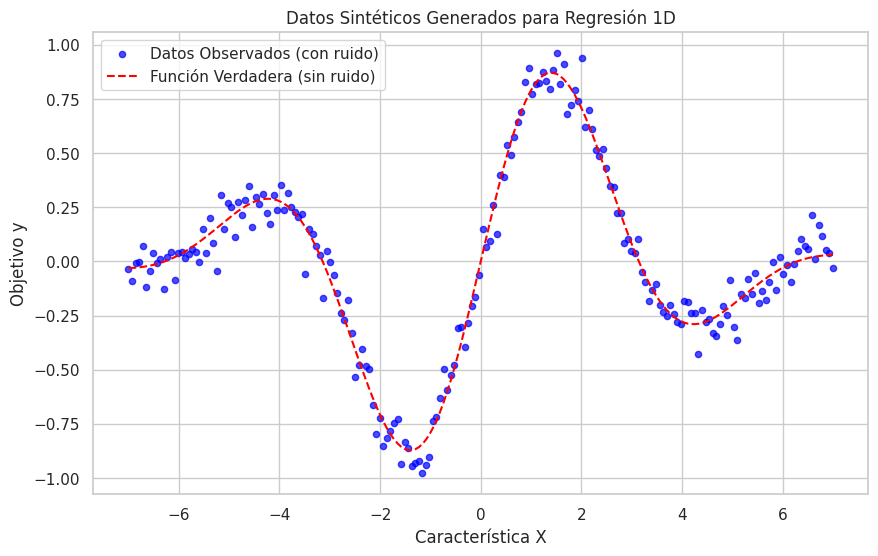


Forma de X_train: (140, 1), y_train: (140,)
Forma de X_test: (60, 1), y_test: (60,)


In [16]:
X_data, y_data = generar_datos_sinteticos_1d(n_puntos=200, rango_x=(-7, 7), ruido_std=0.07)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=42)

print(f"\nForma de X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Forma de X_test: {X_test.shape}, y_test: {y_test.shape}")

# Ordenar los datos de prueba por X para una mejor visualización
sort_idx = np.argsort(X_test[:, 0])
X_test_sorted = X_test[sort_idx]
y_test_sorted = y_test[sort_idx]

### 3.2. Definición de Premisas (MFs Fijas) y Aprendizaje de Consecuentes

Definiendo 7 MFs fijas de tipo 'gaussmf'...


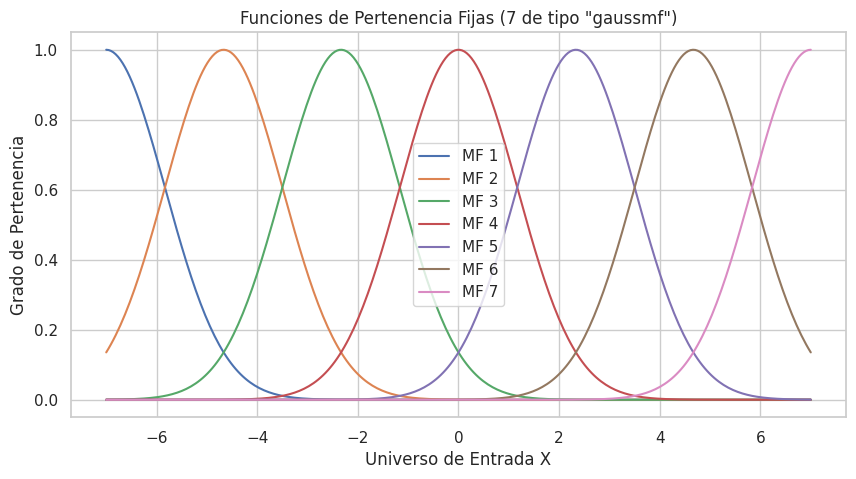

In [17]:
# Paso 1: Definir las funciones de pertenencia para la entrada X
# Usaremos X_train para determinar el rango del universo para las MFs.
num_mfs_config = 7
mf_type_config = 'gaussmf' # Probar 'trimf' o 'gbellmf'
mf_definitions = definir_funciones_pertenencia_fijas(X_train[:,0], num_mfs=num_mfs_config, mf_type=mf_type_config)

In [18]:
# Paso 2: Calcular los grados de activación de las reglas para los datos de entrenamiento
activations_train = calcular_grados_activacion(X_train, mf_definitions)

In [19]:
# Paso 3: Aprender los parámetros de los consecuentes de las reglas Sugeno
# y_train ya es 1D (N_samples,)
learned_consequent_params = aprender_consecuentes_sugeno(X_train, y_train, activations_train)

Aprendiendo parámetros de los consecuentes de las reglas Sugeno...
Parámetros de consecuentes aprendidos (a_i, b_i por regla):
  Regla 1: a_1=-0.383, b_1=-2.813
  Regla 2: a_2=-0.340, b_2=-1.377
  Regla 3: a_3=-0.983, b_3=-2.863
  Regla 4: a_4=0.165, b_4=0.055
  Regla 5: a_5=-0.906, b_5=2.624
  Regla 6: a_6=-0.410, b_6=1.620
  Regla 7: a_7=-0.390, b_7=2.951


### 3.3. Evaluación y Visualización de Resultados


Realizando predicciones en el conjunto de prueba con el modelo Neuro-Fuzzy Híbrido...
Error Cuadrático Medio (MSE) en el conjunto de prueba: 0.0078
Raíz del Error Cuadrático Medio (RMSE) en el conjunto de prueba: 0.0881


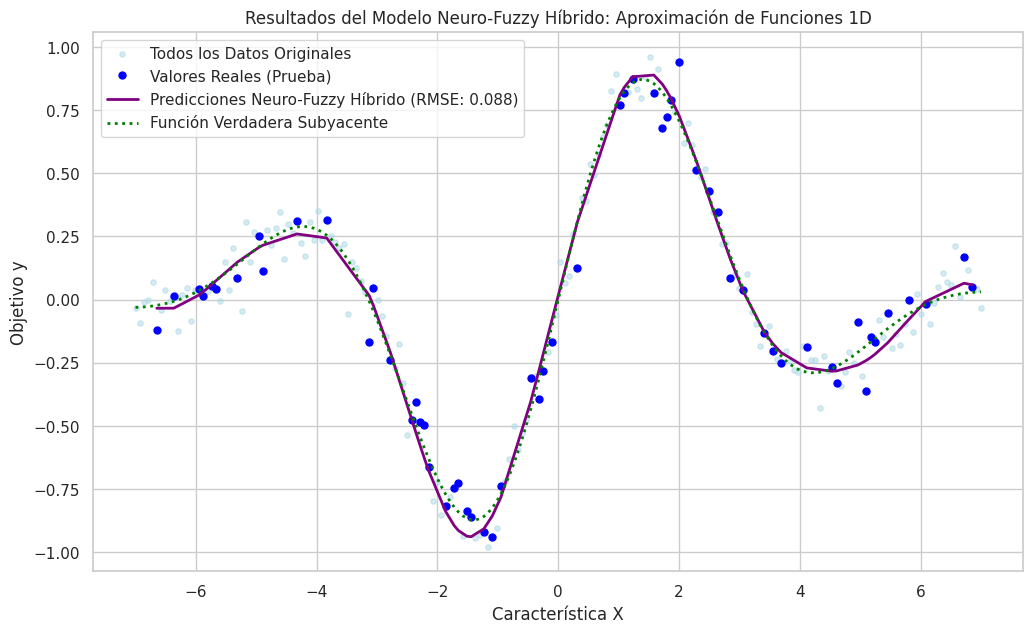

In [20]:
if learned_consequent_params is not None:
    print("\nRealizando predicciones en el conjunto de prueba con el modelo Neuro-Fuzzy Híbrido...")
    y_pred_neuro_fuzzy = predecir_neuro_fuzzy_sugeno(X_test_sorted, mf_definitions, learned_consequent_params)

    mse_nf = mean_squared_error(y_test_sorted, y_pred_neuro_fuzzy)
    rmse_nf = np.sqrt(mse_nf)
    print(f"Error Cuadrático Medio (MSE) en el conjunto de prueba: {mse_nf:.4f}")
    print(f"Raíz del Error Cuadrático Medio (RMSE) en el conjunto de prueba: {rmse_nf:.4f}")

    # Visualizar predicciones vs. valores reales
    plt.figure(figsize=(12, 7))
    plt.scatter(X_data.flatten(), y_data, color='lightblue', label='Todos los Datos Originales', s=15, alpha=0.5)
    plt.plot(X_test_sorted.flatten(), y_test_sorted, 'o', color='blue', label='Valores Reales (Prueba)', markersize=5)
    plt.plot(X_test_sorted.flatten(), y_pred_neuro_fuzzy, '-', color='purple', linewidth=2, label=f'Predicciones Neuro-Fuzzy Híbrido (RMSE: {rmse_nf:.3f})')
    
    # Re-plotear la función verdadera para referencia
    x_original_plot = np.linspace(np.min(X_data[:,0]), np.max(X_data[:,0]), 200)
    y_verdaderos_plot = np.sin(x_original_plot) * np.exp(-(x_original_plot / 4)**2)
    plt.plot(x_original_plot, y_verdaderos_plot, label='Función Verdadera Subyacente', color='green', linestyle=':', linewidth=2)

    plt.title('Resultados del Modelo Neuro-Fuzzy Híbrido: Aproximación de Funciones 1D')
    plt.xlabel('Característica X')
    plt.ylabel('Objetivo y')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No se aprendieron los parámetros de los consecuentes. No se puede evaluar.")

## 4. Conclusiones del Ejercicio

**Resumen de Hallazgos:**
* Se generó un dataset sintético 1D para un problema de regresión no lineal.
* Se implementó un modelo híbrido "Neuro-Fuzzy" donde:
    * Las premisas de las reglas se definieron mediante **[Número, ej: 7]** funciones de pertenencia fijas de tipo **[Tipo, ej: 'gaussmf']** utilizando `scikit-fuzzy`.
    * Los consecuentes de las reglas (asumiendo una estructura Sugeno de primer orden, `y_i = a_i*x + b_i`) se aprendieron utilizando Regresión Lineal sobre los grados de activación de las reglas.
* En el conjunto de prueba, el modelo híbrido alcanzó un RMSE de **[Completar con RMSE obtenido]**.
* La visualización de las predicciones muestra que este enfoque fue capaz de **[Describir el ajuste, ej: capturar la tendencia general de la función no lineal, aunque puede ser menos flexible que un ANFIS completo que también ajusta las MFs]**.

**Sobre el Modelo Híbrido Implementado:**
* **Concepto:** Este modelo es una simplificación de ANFIS. Mantiene la estructura de reglas difusas y la idea de adaptar el sistema a los datos, pero solo adapta los consecuentes.
* **Ventajas:**
    * Utiliza bibliotecas estándar y robustas (`scikit-fuzzy`, `scikit-learn`).
    * Es conceptualmente más simple de implementar que un ANFIS completo desde cero o que depender de bibliotecas ANFIS especializadas que pueden tener problemas de estabilidad/instalación.
    * Aún proporciona cierta interpretabilidad a través de las MFs de entrada (aunque fijas) y los coeficientes de las reglas aprendidas.
* **Limitaciones:**
    * Las funciones de pertenencia de las premisas son fijas. Un ANFIS completo también las adaptaría, lo que generalmente lleva a un mejor rendimiento y flexibilidad.
    * La definición inicial de las MFs (número, tipo, parámetros) sigue siendo crucial y puede requerir ajuste manual o heurísticas.

**Aprendizaje General:**
Este ejercicio demostró una forma práctica de combinar lógica difusa con técnicas de aprendizaje convencionales para abordar problemas de modelado no lineal. Aunque no es un ANFIS completo con aprendizaje de premisas, ilustra el principio de adaptar un sistema basado en reglas difusas a los datos. Este enfoque puede ser un buen punto de partida o una alternativa viable cuando las bibliotecas ANFIS completas presentan desafíos.

*(Nota: Los resultados específicos como el RMSE y las descripciones cualitativas deben completarse después de ejecutar completamente el notebook.)*